## 1. Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import time
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt_tab', quiet=True)

print("Setup complete!")

Setup complete!


## 2. Data Loading & Exploration

Loading datasets...
✓ True.csv: 21417 real articles
✓ Fake.csv: 23481 fake articles
✓ WELFake_Dataset.csv: 35028 real, 37106 fake articles

Using dataset: True.csv + Fake.csv + WELFake_Dataset.csv (Combined & Mixed)
Total samples: 117032
Real: 56445 | Fake: 60587
Label balance: label
0    0.517696
1    0.482304
Name: proportion, dtype: float64
After removing empty texts: 117032 samples


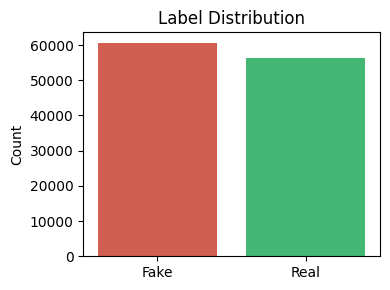

Missing values:
title        558
text          39
label          0
full_text      0
dtype: int64

Final Dataset: 117032 articles | Real: 56445 | Fake: 60587


In [2]:
# Load datasets - Using BOTH True/Fake and WELFake datasets combined
print("Loading datasets...")

# ---------------- Load True / Fake ----------------
real_news_1 = pd.read_csv('True.csv')
fake_news_1 = pd.read_csv('Fake.csv')

# Add labels
real_news_1['label'] = 1
fake_news_1['label'] = 0

# Keep only needed columns
required_cols = ['title', 'text', 'label']
real_news_1 = real_news_1[required_cols]
fake_news_1 = fake_news_1[required_cols]

print(f"✓ True.csv: {len(real_news_1)} real articles")
print(f"✓ Fake.csv: {len(fake_news_1)} fake articles")

# ---------------- Load WELFake ----------------
df_welfake = pd.read_csv('WELFake_Dataset.csv')

# Ensure correct label column
if 'news_label' in df_welfake.columns:
    df_welfake = df_welfake.rename(columns={'news_label': 'label'})

# Check for required columns
missing_cols = [c for c in required_cols if c not in df_welfake.columns]
if missing_cols:
    raise ValueError(f"WELFake_Dataset.csv missing columns: {missing_cols}")

# Keep only needed columns
df_welfake = df_welfake[required_cols]

# 🔥 FIX: WELFake uses 0=real, 1=fake, so we need to FLIP it to match True/Fake convention
df_welfake['label'] = 1 - df_welfake['label']  # Now: 1=real, 0=fake

real_news_2 = df_welfake[df_welfake['label'] == 1].copy()
fake_news_2 = df_welfake[df_welfake['label'] == 0].copy()

print(f"✓ WELFake_Dataset.csv: {len(real_news_2)} real, {len(fake_news_2)} fake articles")

# ---------------- Combine & Mix All Datasets ----------------
# Mix both real and fake from both sources to avoid dataset bias
all_data = []
all_data.append(real_news_1)
all_data.append(fake_news_1)
all_data.append(real_news_2)
all_data.append(fake_news_2)

# Concatenate all data at once
df = pd.concat(all_data, ignore_index=True)

# Shuffle thoroughly with different random state to ensure good mixing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# Second shuffle for extra mixing
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

dataset_name = "True.csv + Fake.csv + WELFake_Dataset.csv (Combined & Mixed)"

# ---------------- Common Processing ----------------
print(f"\n{'='*60}")
print(f"Using dataset: {dataset_name}")
print(f"Total samples: {len(df)}")
print(f"Real: {df['label'].sum()} | Fake: {(df['label']==0).sum()}")
print(f"Label balance: {df['label'].value_counts(normalize=True)}")
print(f"{'='*60}")

# Create full text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Remove any rows with empty full_text
df = df[df['full_text'].str.strip() != ''].reset_index(drop=True)
print(f"After removing empty texts: {len(df)} samples")

# ---------------- Visualization ----------------
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(4, 3))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette=['#e74c3c', '#2ecc71']
)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title('Label Distribution')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ---------------- Info ----------------
print("Missing values:")
print(df.isnull().sum())
print(f"\nFinal Dataset: {len(df)} articles | Real: {df['label'].sum()} | Fake: {len(df) - df['label'].sum()}")

### Data Visualization

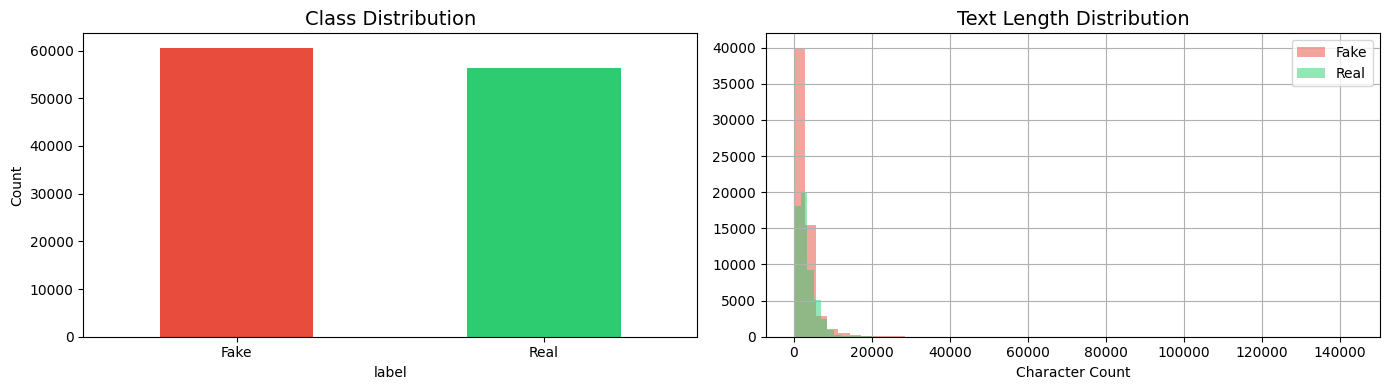

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
colors = ['#e74c3c', '#2ecc71']
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Class Distribution', fontsize=14)
axes[0].set_xticklabels(['Fake', 'Real'], rotation=0)
axes[0].set_ylabel('Count')

# Text length distribution
df['text_length'] = df['full_text'].apply(len)
df[df['label']==0]['text_length'].hist(bins=50, alpha=0.5, label='Fake', ax=axes[1], color='#e74c3c')
df[df['label']==1]['text_length'].hist(bins=50, alpha=0.5, label='Real', ax=axes[1], color='#2ecc71')
axes[1].set_title('Text Length Distribution', fontsize=14)
axes[1].set_xlabel('Character Count')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Train-Test Split (80-20)
X = df['full_text']
y = df['label']

# Verify label distribution before split
print(f"Label distribution before split:")
print(y.value_counts())
print(f"Fake: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"Real: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"  - Fake: {(y_train==0).sum()}, Real: {(y_train==1).sum()}")
print(f"Testing Set: {len(X_test)} samples")
print(f"  - Fake: {(y_test==0).sum()}, Real: {(y_test==1).sum()}")

Label distribution before split:
label
0    60587
1    56445
Name: count, dtype: int64
Fake: 60587 (51.77%)
Real: 56445 (48.23%)

Training Set: 93625 samples
  - Fake: 48469, Real: 45156
Testing Set: 23407 samples
  - Fake: 12118, Real: 11289


In [5]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text: lowercase, remove URLs, HTML, special chars, stopwords, lemmatize"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

print("Preprocessing training data...")
X_train_processed = X_train.apply(preprocess_text)
print("Preprocessing testing data...")
X_test_processed = X_test.apply(preprocess_text)
print("Preprocessing complete!")

Preprocessing training data...
Preprocessing testing data...
Preprocessing complete!


## 4. TF-IDF Vectorization
Convert text to numerical features for traditional ML models

In [6]:
# TF-IDF Vectorizer
# Optimized parameters for combined dataset
tfidf = TfidfVectorizer(
    max_features=5000,  # Increased for larger combined dataset
    ngram_range=(1, 1),  # Include unigrams only
    min_df=100,  # Lowered to capture more features
    max_df=0.1,  # Slightly more strict to remove very common words
    sublinear_tf=True  # Use sublinear term frequency scaling
)

print("Fitting TF-IDF vectorizer...")
X_train_tfidf = tfidf.fit_transform(X_train_processed)
X_test_tfidf = tfidf.transform(X_test_processed)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")

Fitting TF-IDF vectorizer...
TF-IDF Features: 5000
Training samples: 93625
Test samples: 23407


---
## 5. Model Training & Evaluation
Training 2 traditional ML models: Logistic Regression & Random Forest

In [7]:
# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, train_time):
    """Evaluate model and store results"""
    y_pred = model.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Accuracy:      {results[name]['accuracy']:.4f} ({results[name]['accuracy']*100:.2f}%)")
    print(f"Precision:     {results[name]['precision']:.4f}")
    print(f"Recall:        {results[name]['recall']:.4f}")
    print(f"F1-Score:      {results[name]['f1']:.4f}")

### Model 1: Logistic Regression

In [8]:
print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Logistic Regression', lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Logistic Regression...

LOGISTIC REGRESSION
Training Time: 0.61s
Accuracy:      0.9461 (94.61%)
Precision:     0.9454
Recall:        0.9427
F1-Score:      0.9440


### Model 4: Random Forest

In [9]:
print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Random Forest', rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Random Forest...

RANDOM FOREST
Training Time: 17.05s
Accuracy:      0.9389 (93.89%)
Precision:     0.9637
Recall:        0.9074
F1-Score:      0.9347


In [10]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all trained models
print("Saving models...")

# Save TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✓ TF-IDF vectorizer saved")

# Save Logistic Regression
with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Logistic Regression saved")

# Save Random Forest
with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest saved")

print("\nAll models saved successfully in 'models/' directory!")

Saving models...
✓ TF-IDF vectorizer saved
✓ Logistic Regression saved
✓ Random Forest saved

All models saved successfully in 'models/' directory!


---
## 7. Model Comparison & Visualization

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1', 'train_time']]
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string())
print("\n")


MODEL COMPARISON SUMMARY
                     accuracy precision    recall        f1 train_time
Logistic Regression  0.946085  0.945367  0.942688  0.944026   0.611881
Random Forest        0.938864  0.963688  0.907432  0.934714  17.052782




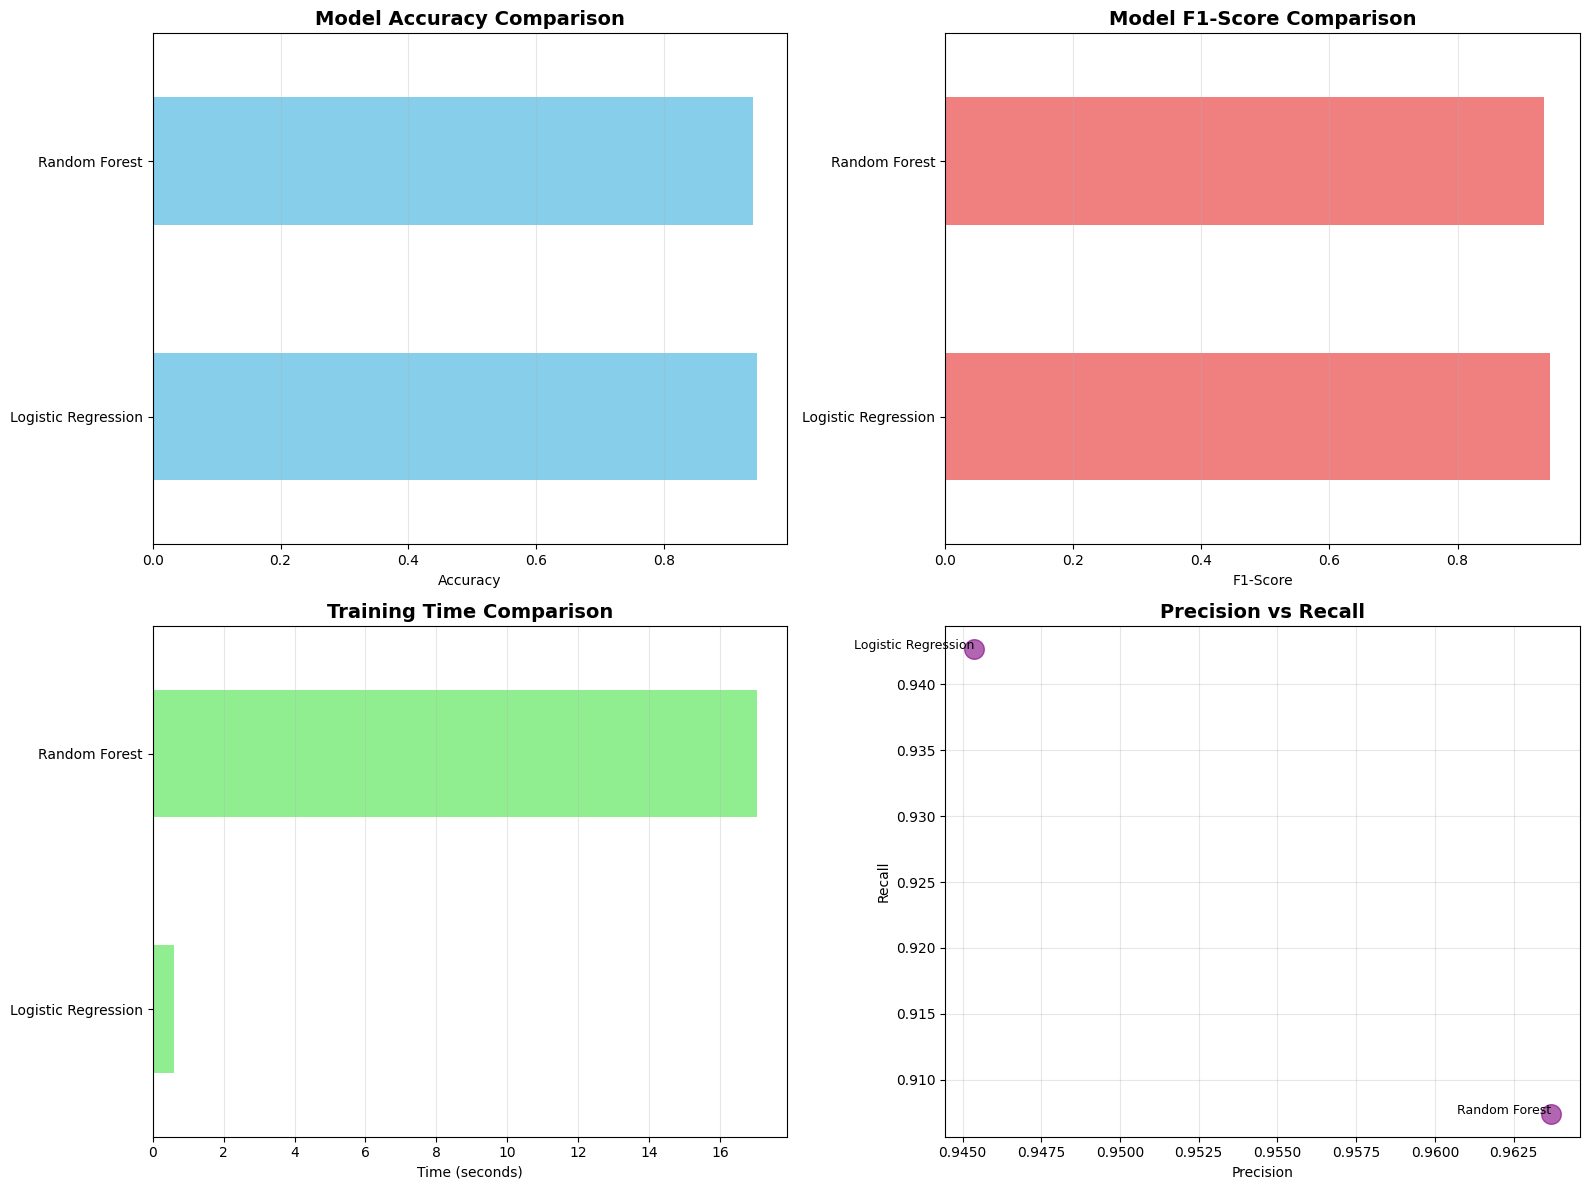

In [12]:
# Visualization 1: Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
comparison_df['accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score
comparison_df['f1'].plot(kind='barh', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# Training Time
comparison_df['train_time'].plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1, 1].scatter(comparison_df['precision'], comparison_df['recall'], s=200, alpha=0.6, color='purple')
for idx, model in enumerate(comparison_df.index):
    axes[1, 1].annotate(model, 
                       (comparison_df['precision'].iloc[idx], comparison_df['recall'].iloc[idx]),
                       fontsize=9, ha='right')
axes[1, 1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

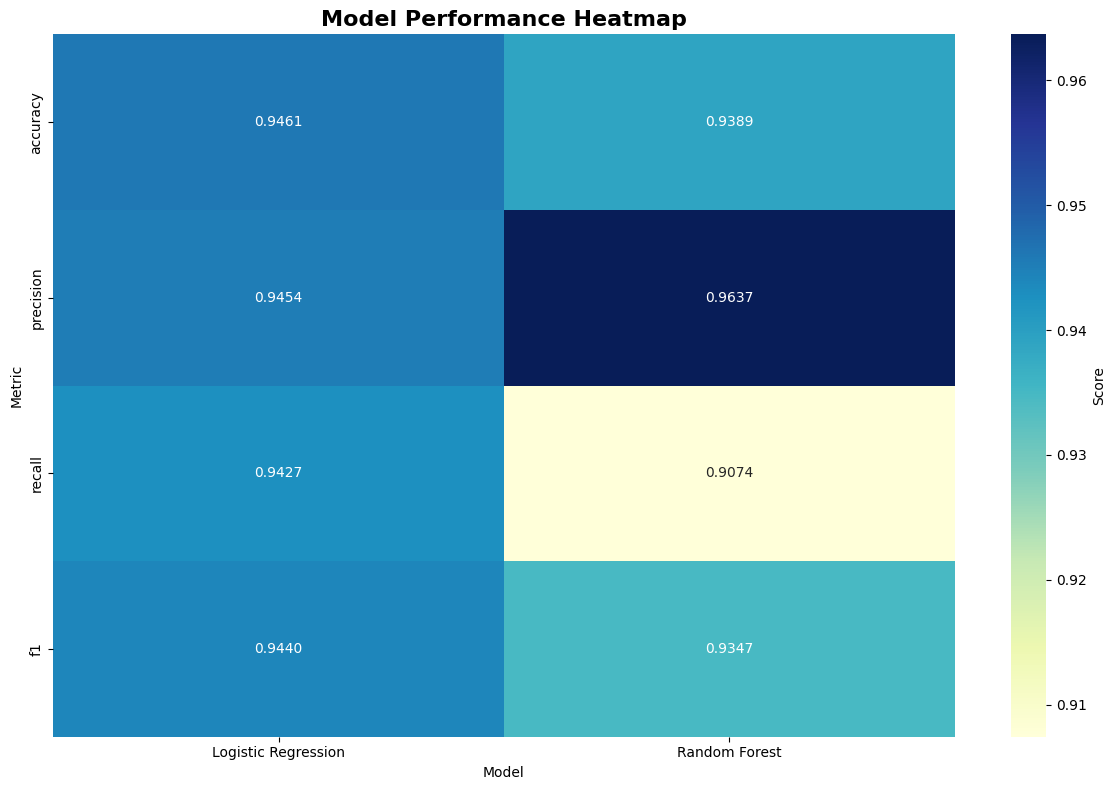

In [13]:
# Visualization 2: All Metrics Heatmap
plt.figure(figsize=(12, 8))
metrics_df = comparison_df[['accuracy', 'precision', 'recall', 'f1']].apply(pd.to_numeric, errors='coerce')
# Replace any non-numeric with NaN then fill (if any) to avoid dtype issues
metrics_df = metrics_df.fillna(0.0)
sns.heatmap(metrics_df.T, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

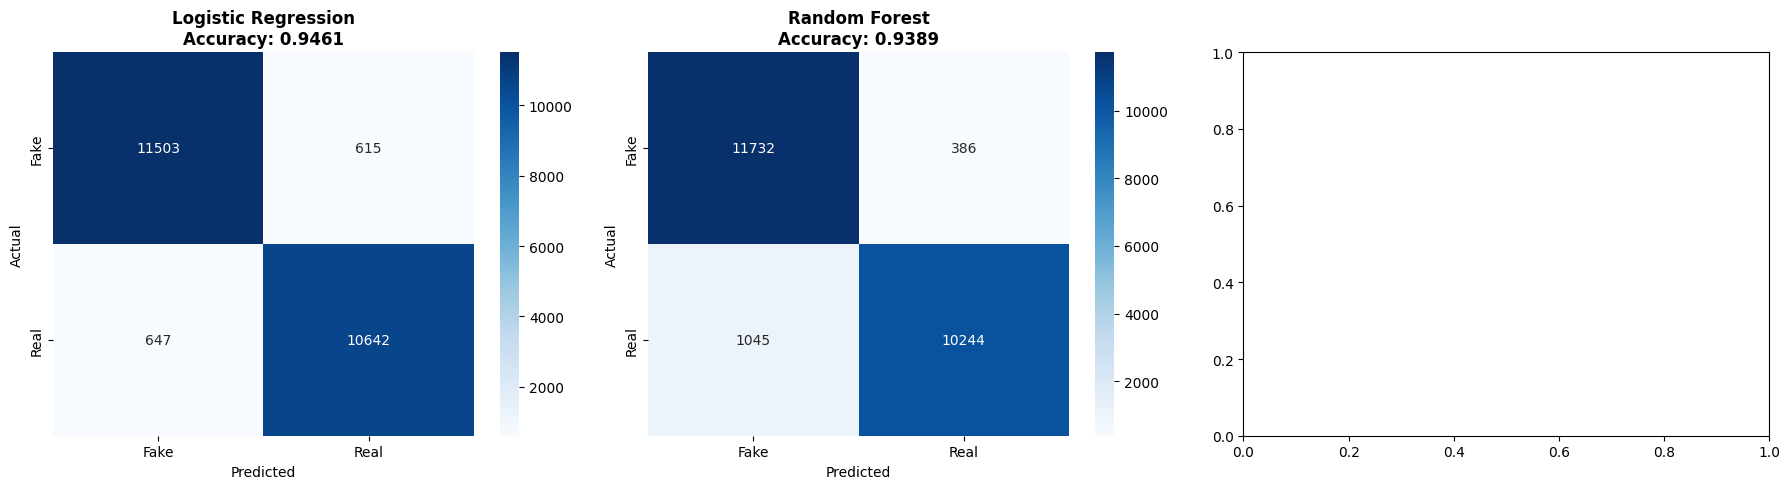

In [14]:
# Visualization 3: Confusion Matrices for Top 3 Models
# Ensure numeric metrics for sorting
comp_numeric = comparison_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1', 'train_time']:
    comp_numeric[col] = pd.to_numeric(comp_numeric[col], errors='coerce')
comp_numeric = comp_numeric.fillna(0.0)

top_3_models = comp_numeric.nlargest(3, 'accuracy').index

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    cm = results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'])
    axes[idx].set_title(f"{model_name}\nAccuracy: {results[model_name]['accuracy']:.4f}", 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

---
## 8. Key Insights & Recommendations

In [15]:
# Find best model
best_model = comparison_df.idxmax()['accuracy']
best_accuracy = comparison_df.loc[best_model, 'accuracy']
fastest_model = comparison_df.idxmin()['train_time']
fastest_time = comparison_df.loc[fastest_model, 'train_time']

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"\n⚡ Fastest Training: {fastest_model}")
print(f"   Training Time: {fastest_time:.2f} seconds")

print("\n📊 RECOMMENDATIONS:")
print("-" * 80)
print("For Production:")
print(f"  • Use {best_model} for highest accuracy")
print(f"  • Use {fastest_model} for fastest inference")
print("\nModel Characteristics:")
print("  • Logistic Regression: Fast, interpretable, good baseline")
print("  • Random Forest: Robust, handles non-linear patterns")
print("\nEnsemble Methods:")
print("  • Hard Voting: Simple majority vote")
print("  • Soft Voting: Average probability predictions")
print("  • Weighted Voting: Weight models by accuracy")
print("="*80)


KEY INSIGHTS

🏆 Best Performing Model: Logistic Regression
   Accuracy: 0.9461 (94.61%)

⚡ Fastest Training: Logistic Regression
   Training Time: 0.61 seconds

📊 RECOMMENDATIONS:
--------------------------------------------------------------------------------
For Production:
  • Use Logistic Regression for highest accuracy
  • Use Logistic Regression for fastest inference

Model Characteristics:
  • Logistic Regression: Fast, interpretable, good baseline
  • Random Forest: Robust, handles non-linear patterns

Ensemble Methods:
  • Hard Voting: Simple majority vote
  • Soft Voting: Average probability predictions
  • Weighted Voting: Weight models by accuracy


---
## 9. Interactive Testing (Optional)
Test models on custom news articles

In [16]:
def _prob_fake_real(model, text_tfidf):
    """Return tuple (p_fake, p_real) for binary models; fall back to 0.5/0.5 if unavailable."""
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
        if len(probs) == 2:
            if hasattr(model, "classes_"):
                cls = list(model.classes_)
                p_fake = probs[cls.index(0)] if 0 in cls else probs[0]
                p_real = probs[cls.index(1)] if 1 in cls else probs[-1]
            else:
                p_fake, p_real = probs[0], probs[1]
            return float(p_fake), float(p_real)
    if hasattr(model, "decision_function"):
        margin = model.decision_function(text_tfidf)[0]
        p_real = 1.0 / (1.0 + np.exp(-margin))
        p_fake = 1.0 - p_real
        return float(p_fake), float(p_real)
    return 0.5, 0.5


def predict_news(text, model_name='Logistic Regression'):
    """Predict if a news article is real or fake with a single model"""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }
    
    if model_name not in model_map:
        print(f"Model '{model_name}' not available. Using Logistic Regression.")
        model_name = 'Logistic Regression'
    
    model = model_map[model_name]
    pred = model.predict(text_tfidf)[0]
    result = "REAL" if pred == 1 else "FAKE"
    p_fake, p_real = _prob_fake_real(model, text_tfidf)
    
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} PREDICTION:")
    print("-" * 60)
    print(f"Prediction: {result} {'✔' if result=='REAL' else '✗'}")
    print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
    print(f"{'='*60}")
    return result


def predict_all_models(text):
    """Predict with every available model; print prediction and confidence."""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }
    
    summary = {}
    for name, model in model_map.items():
        pred = model.predict(text_tfidf)[0]
        label = 'REAL' if pred == 1 else 'FAKE'
        p_fake, p_real = _prob_fake_real(model, text_tfidf)
        acc = results.get(name, {}).get('accuracy', None)
        summary[name] = {
            'prediction': label,
            'p_fake': p_fake,
            'p_real': p_real,
            'accuracy': acc,
        }
        acc_display = f" | accuracy: {acc:.4f}" if acc is not None else ""
        print(f"\n{name.upper()} PREDICTION:")
        print("-" * 60)
        print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
        print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    
    return summary

In [17]:
sample_text = """
Iran warns it will retaliate if US attacks, as hundreds killed in protests
Iran has warned it will retaliate if attacked by the US, as BBC sources and activists report hundreds of protesters have now been killed in an escalating government crackdown.

"Things here are very, very bad," a source in Tehran said on Sunday. "A lot of our friends have been killed. They were firing live rounds. It's like a war zone, the streets are full of blood. They're taking away bodies in trucks."

The BBC counted about 180 body bags in footage from a morgue near Tehran. The US-based Human Rights Activist News Agency says it has verified the deaths of 495 protesters and 48 security personnel nationwide.

Another 10,600 people have been detained over the fortnight of unrest, the agency says.

The US has threatened to intervene in Iran over the killing of protesters, but on Sunday, US President Donald Trump said that Iranian leaders had called him and that "they want to negotiate".

He added, however, that the US "may have to act before a meeting".

Trump has not elaborated on what the US is considering, but on Sunday he said "we're looking at some very strong options". He has been briefed on options for military strikes on Iran, an official told the BBC's US news partner CBS.

Other approaches could include boosting anti-government sources online, using cyber-weapons against Iran's military, or imposing more sanctions, officials told the Wall Street Journal.

Iran's parliament speaker warned that if the US attacked, both Israel and US military and shipping centres in the region would become legitimate targets.

The protests which began over soaring inflation are now calling for an end to the clerical rule of Iran's Supreme Leader, Ayatollah Ali Khamenei.

Iran's attorney general said anyone protesting would be considered an "enemy of God" - an offence that carries the death penalty - while Khamenei has dismissed demonstrators as a "bunch of vandals" seeking to "please" Trump.

On Sunday the country announced three days of mourning for what it called "martyrs killed in Iranian national battle against the US and Israel".

Staff at several hospitals have told the BBC they have been overwhelmed with dead or injured protesters in recent days.

BBC Persian has verified that 70 bodies were brought to one hospital in the city of Rasht on Friday night, while a health worker at a Tehran hospital told the BBC: "Around 38 people died. Many as soon as they reached the emergency beds... direct shots to the heads of the young people, to their hearts as well. Many of them didn't even make it to the hospital."

The BBC and most other international news organisations are unable to report from inside Iran, and the Iranian government has imposed an internet shutdown since Thursday, making obtaining and verifying information difficult.

Some footage has emerged, including video showing rows of body bags at the Forensic Diagnostic and Laboratory Center of Tehran Province - a morgue in Kahrizak.

In one video from the site, about 180 shrouded or wrapped figures can be seen, the majority lying out in the open. Shouts and cries of distress can be heard from people who appear to be looking for their loved ones.

Footage has been blurred to protect the identities of the living, who could face further persecution from the authorities.

Several videos confirmed as recent by BBC Verify show clashes between protesters and security forces in Mashhad, Iran's second-largest city.

Masked protesters can be seen taking cover behind bins and bonfires, with a row of security forces in the distance. A vehicle that appears to be a bus is engulfed in flames.

Multiple gunshots can be heard, and what sounds like banging on pots and pans.

A figure standing on a nearby footbridge appears to fire multiple gunshots in several directions as a couple of people take cover behind a fence.

In Tehran, a verified video from Saturday night shows protesters taking over the streets in the Gisha district, the sound of banging on pots in Punak Square, and a crowd marching and calling for the end of clerical rule in the Heravi district.

"""
#https://www.bbc.com/news/articles/cm2jek15m8no the link for real news
predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=5.77%, Real=94.23% | accuracy: 0.9461

RANDOM FOREST PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=30.88%, Real=69.12% | accuracy: 0.9389


{'Logistic Regression': {'prediction': 'REAL',
  'p_fake': 0.0577012486688111,
  'p_real': 0.9422987513311889,
  'accuracy': 0.9460845046353655},
 'Random Forest': {'prediction': 'REAL',
  'p_fake': 0.308779403994375,
  'p_real': 0.6912205960056248,
  'accuracy': 0.9388644422608622}}

---
## 10. Ensemble Learning
Combining multiple models for improved predictions

In [18]:
# Ensemble Methods: Combining predictions from LR and RF only

import warnings
warnings.filterwarnings('ignore')  # Suppress sklearn parallel warnings

print("="*80)
print("ENSEMBLE LEARNING - COMBINING LR & RF")
print("="*80)

# Method 1: Hard Voting (Majority Vote) - LR + RF
print("\n1. HARD VOTING ENSEMBLE (Majority Vote)")
print("-" * 80)

# Efficient vectorized predictions
lr_pred = lr_model.predict(X_test_tfidf)
rf_pred = rf_model.predict(X_test_tfidf)

# Combine predictions: if both agree, use that; if disagree, use LR (higher accuracy)
y_pred_hard = np.where(lr_pred == rf_pred, lr_pred, lr_pred)

hard_voting_acc = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting Accuracy: {hard_voting_acc:.4f} ({hard_voting_acc*100:.2f}%)")
print(f"Combining: Logistic Regression + Random Forest")

results['Hard Voting Ensemble'] = {
    'accuracy': hard_voting_acc,
    'precision': precision_score(y_test, y_pred_hard),
    'recall': recall_score(y_test, y_pred_hard),
    'f1': f1_score(y_test, y_pred_hard),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_hard)
}

# Method 2: Soft Voting (Average Probabilities) - LR + RF
print("\n2. SOFT VOTING ENSEMBLE (Probability Averaging)")
print("-" * 80)

# Get probability predictions
lr_probs = lr_model.predict_proba(X_test_tfidf)
rf_probs = rf_model.predict_proba(X_test_tfidf)

# Average probabilities
avg_probs = (lr_probs + rf_probs) / 2
y_pred_soft = (avg_probs[:, 1] >= 0.5).astype(int)

soft_voting_acc = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Accuracy: {soft_voting_acc:.4f} ({soft_voting_acc*100:.2f}%)")
print(f"Combining: Logistic Regression + Random Forest")

results['Soft Voting Ensemble'] = {
    'accuracy': soft_voting_acc,
    'precision': precision_score(y_test, y_pred_soft),
    'recall': recall_score(y_test, y_pred_soft),
    'f1': f1_score(y_test, y_pred_soft),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_soft)
}

# Method 3: Weighted Voting (Based on model accuracy) - LR + RF
print("\n3. WEIGHTED VOTING ENSEMBLE")
print("-" * 80)

# Use accuracy as weights
lr_weight = results['Logistic Regression']['accuracy']
rf_weight = results['Random Forest']['accuracy']

total_weight = lr_weight + rf_weight

# Weighted average of probabilities
weighted_probs = (lr_probs * lr_weight + rf_probs * rf_weight) / total_weight
y_pred_weighted = (weighted_probs[:, 1] >= 0.5).astype(int)

weighted_voting_acc = accuracy_score(y_test, y_pred_weighted)
print(f"Weighted Voting Accuracy: {weighted_voting_acc:.4f} ({weighted_voting_acc*100:.2f}%)")
print(f"Weights: LR={lr_weight:.4f}, RF={rf_weight:.4f}")

results['Weighted Voting Ensemble'] = {
    'accuracy': weighted_voting_acc,
    'precision': precision_score(y_test, y_pred_weighted),
    'recall': recall_score(y_test, y_pred_weighted),
    'f1': f1_score(y_test, y_pred_weighted),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_weighted)
}

print("\n" + "="*80)
print("ENSEMBLE RESULTS SUMMARY")
print("="*80)
ensemble_comparison = pd.DataFrame({
    'Hard Voting': [results['Hard Voting Ensemble']['accuracy']],
    'Soft Voting': [results['Soft Voting Ensemble']['accuracy']],
    'Weighted Voting': [results['Weighted Voting Ensemble']['accuracy']]
})
print(ensemble_comparison.T.to_string())
print("="*80)

ENSEMBLE LEARNING - COMBINING LR & RF

1. HARD VOTING ENSEMBLE (Majority Vote)
--------------------------------------------------------------------------------
Hard Voting Accuracy: 0.9461 (94.61%)
Combining: Logistic Regression + Random Forest

2. SOFT VOTING ENSEMBLE (Probability Averaging)
--------------------------------------------------------------------------------
Soft Voting Accuracy: 0.9564 (95.64%)
Combining: Logistic Regression + Random Forest

3. WEIGHTED VOTING ENSEMBLE
--------------------------------------------------------------------------------
Weighted Voting Accuracy: 0.9564 (95.64%)
Weights: LR=0.9461, RF=0.9389

ENSEMBLE RESULTS SUMMARY
                        0
Hard Voting      0.946085
Soft Voting      0.956423
Weighted Voting  0.956423


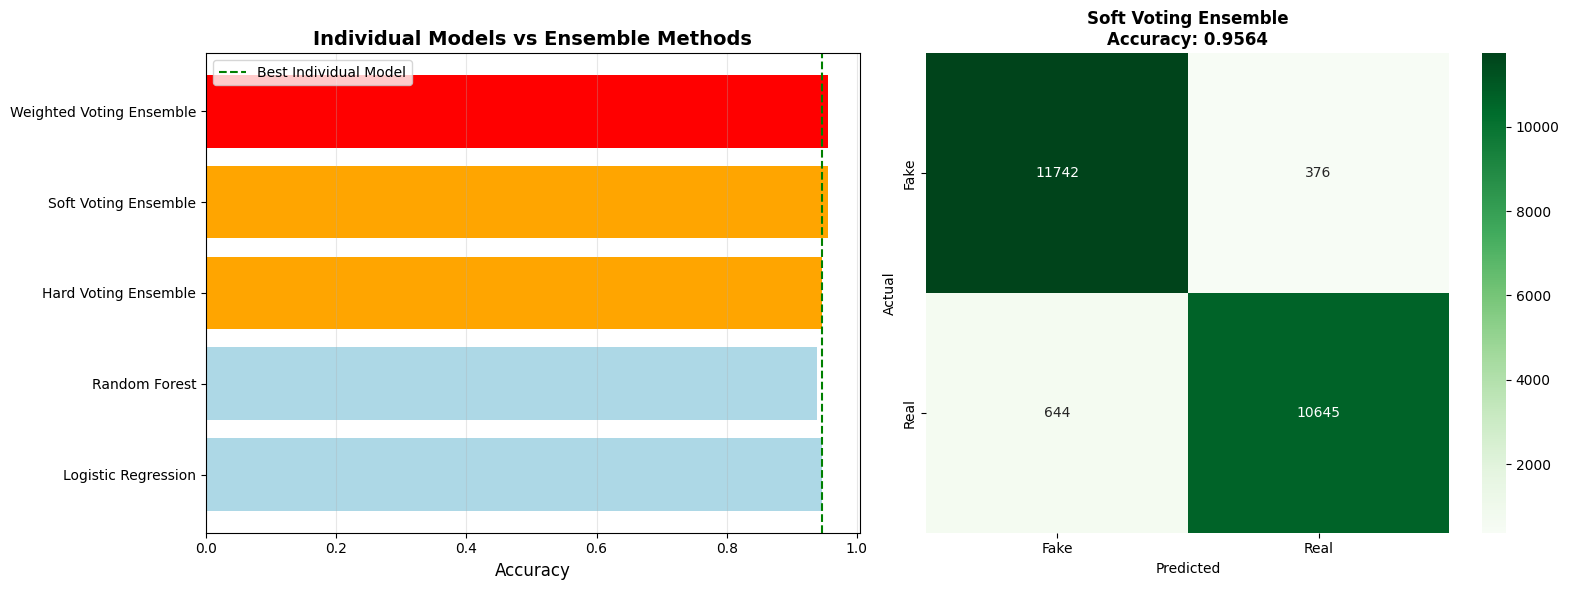


🏆 Best Ensemble Method: Soft Voting Ensemble
   Accuracy: 0.9564 (95.64%)


In [19]:
# Visualize Ensemble Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Compare individual models vs ensemble
ensemble_models = ['Logistic Regression', 'Random Forest', 
                   'Hard Voting Ensemble', 'Soft Voting Ensemble', 'Weighted Voting Ensemble']
ensemble_acc = [results[m]['accuracy'] for m in ensemble_models]

colors_list = ['lightblue', 'lightblue', 'orange', 'orange', 'red']
axes[0].barh(ensemble_models, ensemble_acc, color=colors_list)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Individual Models vs Ensemble Methods', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=max([results[m]['accuracy'] for m in ['Logistic Regression', 'Random Forest']]), 
                color='green', linestyle='--', label='Best Individual Model')
axes[0].legend()

# Confusion Matrix for Best Ensemble
best_ensemble = max(['Hard Voting Ensemble', 'Soft Voting Ensemble', 'Weighted Voting Ensemble'], 
                    key=lambda x: results[x]['accuracy'])
cm = results[best_ensemble]['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
axes[1].set_title(f"{best_ensemble}\nAccuracy: {results[best_ensemble]['accuracy']:.4f}", 
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print(f"\n🏆 Best Ensemble Method: {best_ensemble}")
print(f"   Accuracy: {results[best_ensemble]['accuracy']:.4f} ({results[best_ensemble]['accuracy']*100:.2f}%)")